Author: Filip Bucko  
Email: xbucko05@vutbr.cz  
Institution: Brno University of Technology - Faculty of Information Technology  
Date: 18.5.2024

# Malicious Domain Detection via DNS Data Analysis and Transformer Modeling

## Overview

This notebook details the analysis of DNS metadata to distinguish **phishing domains** from benign ones. The final objective is to prepare the data for a transformer-based classification model by identifying, cleaning, and formatting informative DNS features.



## Workflow Summary

- **Phase 1**: Preprocessing and flattening JSON-formatted DNS data  
- **Phase 2**: Missing value analysis and feature filtering  
- **Phase 3**: Transformer-compatible input construction



## Expected Outcome

By the end of this notebook:
- You will have a clean and labeled DNS dataset (phishing + benign)
- You will understand which metadata fields are most useful for classification
- You will have a formatted input ready for transformer tokenization and training


## Phase 1: JSON Preprocessing and Flattening

**Goal:**  
Convert raw DNS metadata (exported as line-delimited JSON) into structured, tabular form for downstream analysis.

**Input Format:**
Each line in the JSON file contains a document with:
- `"domain_name"`: the domain string
- `"dns"`: a nested dictionary of DNS fields

**Processing Steps:**
1. Load records line-by-line from the JSON file
2. Flatten nested fields using `pandas.json_normalize()`
3. Drop system-generated fields (e.g., `_id`)
4. Optionally remove prefixes like `dns.` from column names for clarity

**Output:**  
A `pandas.DataFrame` with one row per domain and columns for each extracted DNS feature.


In [1]:
# Standard libraries
import json
import random
from pathlib import Path
from typing import Dict, List, Optional

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter display utilities
from IPython.display import HTML


In [2]:
def render_dataframe(df: pd.DataFrame, max_rows: int = 100, max_cols: int = 50) -> HTML:
    """
    Render a scrollable and truncated HTML preview of a DataFrame (for Jupyter notebooks).
    """
    styles = [
        {"selector": "th", "props": [("max-width", "200px")]},
        {"selector": "td", "props": [("max-width", "200px"), ("overflow", "auto"), ("text-overflow", "ellipsis")]}
    ]
    return HTML(
        df.head(max_rows)
          .style.set_table_styles(styles)
          .set_table_attributes('style="display:inline-block;overflow:auto;max-height:500px;"')
          .to_html()
    )

def read_json_file(file_path: str) -> pd.DataFrame:
    """
    Load and flatten a DNS JSONL file into a DataFrame.
    """
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]

    df = pd.json_normalize(data, sep='.')
    df.drop(columns=[col for col in df.columns if col.startswith('_id')], inplace=True, errors='ignore')
    df.columns = [col.replace('dns.', '') for col in df.columns]
    return df


In [3]:
def _sample_jsonl_lines(file_path: str, sample_size: int, total_lines: int, seed: int) -> List[Dict]:
    """
    Randomly sample a fixed number of lines from a JSONL file using a 2-pass strategy.

    Args:
        file_path (str): Path to the JSONL file.
        sample_size (int): Number of lines to sample.
        total_lines (int): Total number of lines in the file.
        seed (int): Random seed for reproducibility.

    Returns:
        List[Dict]: List of parsed JSON objects.
    """
    random.seed(seed)
    selected_indices = set(random.sample(range(total_lines), sample_size))
    data = []

    with open(file_path, "r") as f:
        for i, line in enumerate(f):
            if i in selected_indices:
                data.append(json.loads(line))
            if len(data) >= sample_size:
                break

    return data

def read_json_file_to_df(file_path: str, sample_size: Optional[int] = None,
                         seed: int = 42, flatten_depth: Optional[int] = None) -> pd.DataFrame:
    """
    Load a DNS JSONL file and return a flattened DataFrame. Optionally sample a subset of records
    and control flattening depth.

    Args:
        file_path (str): Path to the JSONL file.
        sample_size (int, optional): If set, sample this many lines from the file.
        seed (int): Random seed for sampling.
        flatten_depth (int, optional): Maximum depth for flattening nested keys. If None, flatten fully.

    Returns:
        pd.DataFrame: Flattened DataFrame of DNS metadata.
    """
    with open(file_path, 'r') as f:
        total_lines = sum(1 for _ in f)

    if sample_size is None or sample_size >= total_lines:
        with open(file_path, 'r') as f:
            data = [json.loads(line) for line in f]
    else:
        data = _sample_jsonl_lines(file_path, sample_size, total_lines, seed)

    df = pd.json_normalize(data, sep='.', max_level=flatten_depth if flatten_depth else None)

    df.drop(columns=[col for col in df.columns if col.startswith('_id')], inplace=True, errors='ignore')
    df.columns = [col.replace('dns.', '') for col in df.columns]

    return df


### Benign

In [4]:
# Resolve project root
project_root = Path.cwd().parent.parent
benign_file_path = project_root / "datasets" / "benign" / "benign_2312_anonymized_dns_2024.json"
benign_df = read_json_file_to_df(benign_file_path, sample_size=160_000, flatten_depth=1)
render_dataframe(benign_df)

,domain_name,A,AAAA,CNAME,MX,NS,TXT,SOA,zone_SOA,dnssec,remarks,sources,ttls,NAPTR
0,00000fs3085d.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
1,0000100b00e9.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
2,0000100q012c.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
3,0000102n02c4.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
4,0000102n02d5.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
5,0000102n03d3.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
6,0000102n0434.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}

In [5]:
# Inspect the structure of the benign dataset
print("Benign dataset overview:")
benign_df.info()
print("\nBenign columns:")
print(benign_df.columns.to_list())


Benign dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   domain_name  160000 non-null  object
 1   A            131619 non-null  object
 2   AAAA         34528 non-null   object
 3   CNAME        16210 non-null   object
 4   MX           83075 non-null   object
 5   NS           98681 non-null   object
 6   TXT          81208 non-null   object
 7   SOA          99055 non-null   object
 8   zone_SOA     60536 non-null   object
 9   dnssec       158027 non-null  object
 10  remarks      158027 non-null  object
 11  sources      158027 non-null  object
 12  ttls         158027 non-null  object
 13  NAPTR        46 non-null      object
dtypes: object(14)
memory usage: 17.1+ MB

Benign columns:
['domain_name', 'A', 'AAAA', 'CNAME', 'MX', 'NS', 'TXT', 'SOA', 'zone_SOA', 'dnssec', 'remarks', 'sources', 'ttls', 'NAPTR']


### Phishing

In [6]:
# Now build the path to the JSON file in datasets/malware/
json_file_path = project_root / "datasets" / "phishing" / "phishing_strict_dns_2024.json"
phish_df = read_json_file_to_df(json_file_path, flatten_depth=1)
render_dataframe(phish_df)

,domain_name,A,AAAA,CNAME,MX,NS,TXT,SOA,zone_SOA,dnssec,remarks,sources,ttls
0,conflrma57843.com,"['188.114.97.9', '188.114.96.9']","['2a06:98c1:3121::9', '2a06:98c1:3120::9']",None,None,"{'aisha.ns.cloudflare.com': {'related_ips': [{'ttl': 82617, 'value': '108.162.194.186'}, {'ttl': 82617, 'value': '162.159.38.186'}, {'ttl': 82617, 'value': '172.64.34.186'}, {'ttl': 81928, 'value': '2803:f800:50::6ca2:c2ba'}, {'ttl': 81928, 'value': '2a06:98c1:50::ac40:22ba'}, {'ttl': 81928, 'value': '2606:4700:50::a29f:26ba'}]}, 'rommy.ns.cloudflare.com': {'related_ips': [{'ttl': 54785, 'value': '108.162.195.20'}, {'ttl': 54785, 'value': '162.159.44.20'}, {'ttl': 54785, 'value': '172.64.35.20'}, {'ttl': 60359, 'value': '2803:f800:50::6ca2:c314'}, {'ttl': 60359, 'value': '2a06:98c1:50::ac40:2314'}, {'ttl': 60359, 'value': '2606:4700:58::a29f:2c14'}]}}",None,"{'primary_ns': 'aisha.ns.cloudflare.com', 'resp_mailbox_dname': 'dns.cloudflare.com', 'serial': 2339702964, 'refresh': 10000, 'retry': 2400, 'expire': 604800, 'min_ttl': 1800}",None,"{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'conflrma57843.com'}","{'A': 0, 'AAAA': 0, 'SOA': 0, 'CNAME': 2, 'MX': 2, 'NS': 0, 'TXT': 2, 'NAPTR': 2}","{'A': 300, 'AAAA': 300, 'SOA': 1800, 'CNAME': 0, 'MX': 0, 'NS': 86400, 'TXT': 0, 'NAPTR': 0}"
1,www.zgahdjm.com,None,None,None,None,None,None,None,None,nan,nan,nan,nan
2,attt.pages.dev,"['172.66.44.147', '172.66.47.109']","['2606:4700:310c::ac42:2c93', '2606:4700:310c::ac42:2f6d']",None,None,"{'lily.ns.cloudflare.com': {'related_ips': [{'ttl': 85625, 'value': '173.245.58.130'}, {'ttl': 85625, 'value': '108.162.192.130'}, {'ttl': 85625, 'value': '172.64.32.130'}, {'ttl': 83677, 'value': '2606:4700:50::adf5:3a82'}, {'ttl': 83677, 'value': '2803:f800:50::6ca2:c082'}, {'ttl': 83677, 'value': '2a06:98c1:50::ac40:2082'}]}, 'watson.ns.cloudflare.com': {'related_ips': [{'ttl': 83409, 'value': '172.64.35.23'}, {'ttl': 83409, 'value': '108.162.195.23'}, {'ttl': 83409, 'value': '162.159.44.23'}, {'ttl': 84450, 'value': '2606:4700:58::a29f:2c17'}, {'ttl': 84450, 'value': '2803:f800:50::6ca2:c317'}, {'ttl': 84450, 'value': '2a06:98c1:50::ac40:2317'}]}}",None,"{'primary_ns': 'lily.ns.cloudflare.com', 'resp_mailbox_dname': 'dns.cloudflare.com', 'serial': 2327161952, 'refresh': 10000, 'retry': 2400, 'expire': 604800, 'min_ttl': 1800}",None,"{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'attt.pages.dev'}","{'A': 0, 'AAAA': 0, 'SOA': 0, 'CNAME': 2, 'MX': 2, 'NS': 0, 'TXT': 2, 'NAPTR': 2}","{'A': 300, 'AAAA': 300, 'SOA': 1800, 'CNAME': 0, 'MX': 0, 'NS': 86400, 'TXT': 0, 'NAPTR': 0}"
3,chermate.weeblysite.com,"['162.159.140.60', '172.66.0.60']",None,None,None,None,None,None,"{'primary_ns': 'dns1.p08.nsone.net', 'resp_mailbox_dname': 'hostmaster.nsone.net', 'serial': 1647889018, 'refresh': 43200, 'retry': 7200, 'expire': 1209600, 'min_ttl': 3600}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'weeblysite.com'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 900, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}"
4,allegrolokalnie.oferta73.pl,['84.32.84.33'],None,None,None,"{'ns1.dns-expired.com': {'related_ips': [{'ttl': 14147, 'value': '89.116.146.145'}]}, 'ns2.dns-expired.com': {'related_ips': [{'ttl': 14730, 'value': '89.116.146.146'}]}}",['this domain is expired at hostinger!'],"{'primary_ns': 'ns1.dns-expired.com', 'resp_mailbox_dname': 'hostmaster.hostinger.com', 'serial': 2023081800, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 3600}",None,"{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'al

In [7]:
# Inspect the structure of the phishing dataset
print("Phishing dataset overview:")
phish_df.info()
print("\nPhishing columns:")
print(benign_df.columns.to_list())

Phishing dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164425 entries, 0 to 164424
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   domain_name  164425 non-null  object
 1   A            113923 non-null  object
 2   AAAA         49022 non-null   object
 3   CNAME        25848 non-null   object
 4   MX           15052 non-null   object
 5   NS           32543 non-null   object
 6   TXT          24783 non-null   object
 7   SOA          33121 non-null   object
 8   zone_SOA     127602 non-null  object
 9   dnssec       160052 non-null  object
 10  remarks      160052 non-null  object
 11  sources      160052 non-null  object
 12  ttls         160052 non-null  object
dtypes: object(13)
memory usage: 16.3+ MB

Phishing columns:
['domain_name', 'A', 'AAAA', 'CNAME', 'MX', 'NS', 'TXT', 'SOA', 'zone_SOA', 'dnssec', 'remarks', 'sources', 'ttls', 'NAPTR']


## Phase 2: Missing Value Analysis and Feature Filtering

This phase evaluates DNS fields for their relevance in classification, focusing on patterns of missing data across the benign and malicious datasets.

**Objective:**  
Eliminate fields that are unlikely to contribute meaningfully to a machine learning model due to excessive missing values or lack of variation between classes.

**Methodology:**
- Identify and drop columns that are entirely empty
- Quantify and visualize missingness across both datasets
- Apply statistical tests (e.g., Chi-square) to assess whether missingness correlates with the class label
- Drop fields that are both largely missing and statistically uninformative

## Handling of missing values

### Columns with any NaN (missing values)

In [8]:
# Identify columns with any NaN values in each dataset
benign_nan_cols = benign_df.columns[benign_df.isna().any()].tolist()
phish_nan_cols = phish_df.columns[phish_df.isna().any()].tolist()

print("Benign dataset:")
print(f"  Columns with missing values: {len(benign_nan_cols)} / {benign_df.shape[1]}")
print("---------------------------------------------------------------")

print("Phishing dataset:")
print(f"  Columns with missing values: {len(phish_nan_cols)} / {phish_df.shape[1]}")


Benign dataset:
  Columns with missing values: 13 / 14
---------------------------------------------------------------
Phishing dataset:
  Columns with missing values: 12 / 13


### Columns That Are Fully Empty (All Values Are NaN)
These columns can be fully dropped

In [9]:
# Identify columns that are completely empty (all NaN)
fully_nan_benign = benign_df.columns[benign_df.isna().all()].tolist()
fully_nan_phish = phish_df.columns[phish_df.isna().all()].tolist()

print("Benign:")
print(f"  Fully empty columns: {fully_nan_benign}")
print(f"  Shape before drop: {benign_df.shape}")
benign_df.drop(columns=fully_nan_benign, inplace=True)
print(f"  Shape after drop: {benign_df.shape}")
print("---------------------------------------------------------------")

print("Phishing:")
print(f"  Fully empty columns: {fully_nan_phish}")
print(f"  Shape before drop: {phish_df.shape}")
phish_df.drop(columns=fully_nan_phish, inplace=True)
print(f"  Shape after drop: {phish_df.shape}")


Benign:
  Fully empty columns: []
  Shape before drop: (160000, 14)
  Shape after drop: (160000, 14)
---------------------------------------------------------------
Phishing:
  Fully empty columns: []
  Shape before drop: (164425, 13)
  Shape after drop: (164425, 13)


In [10]:
# Display phishing columns that still contain missing values (non-zero only)
phish_missing = phish_df.isna().sum()
print("Phishing columns with missing values:")
print(phish_missing[phish_missing > 0])

Phishing columns with missing values:
A            50502
AAAA        115403
CNAME       138577
MX          149373
NS          131882
TXT         139642
SOA         131304
zone_SOA     36823
dnssec        4373
remarks       4373
sources       4373
ttls          4373
dtype: int64


In [11]:
# Compare feature columns between benign and phishing datasets
common_columns = set(benign_df.columns) & set(phish_df.columns)
different_columns = set(benign_df.columns) - set(phish_df.columns)

print(f"Common columns ({len(common_columns)}):")
print(sorted(common_columns))

print("\nColumns in benign only (not in phishing) — total:", len(different_columns))
print(sorted(different_columns))

Common columns (13):
['A', 'AAAA', 'CNAME', 'MX', 'NS', 'SOA', 'TXT', 'dnssec', 'domain_name', 'remarks', 'sources', 'ttls', 'zone_SOA']

Columns in benign only (not in phishing) — total: 1
['NAPTR']


In [12]:
# Drop columns from benign_df that are not present in phishing_df
benign_df.drop(columns=different_columns, inplace=True)
print(f"benign_df shape after aligning columns: {benign_df.shape}")


benign_df shape after aligning columns: (160000, 13)


In [13]:
# Confirm schema consistency after column alignment
print("Benign dataset (aligned):")
benign_df.info()

print("\nPhishing dataset:")
phish_df.info()


Benign dataset (aligned):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   domain_name  160000 non-null  object
 1   A            131619 non-null  object
 2   AAAA         34528 non-null   object
 3   CNAME        16210 non-null   object
 4   MX           83075 non-null   object
 5   NS           98681 non-null   object
 6   TXT          81208 non-null   object
 7   SOA          99055 non-null   object
 8   zone_SOA     60536 non-null   object
 9   dnssec       158027 non-null  object
 10  remarks      158027 non-null  object
 11  sources      158027 non-null  object
 12  ttls         158027 non-null  object
dtypes: object(13)
memory usage: 15.9+ MB

Phishing dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164425 entries, 0 to 164424
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       -

<Figure size 1200x600 with 0 Axes>

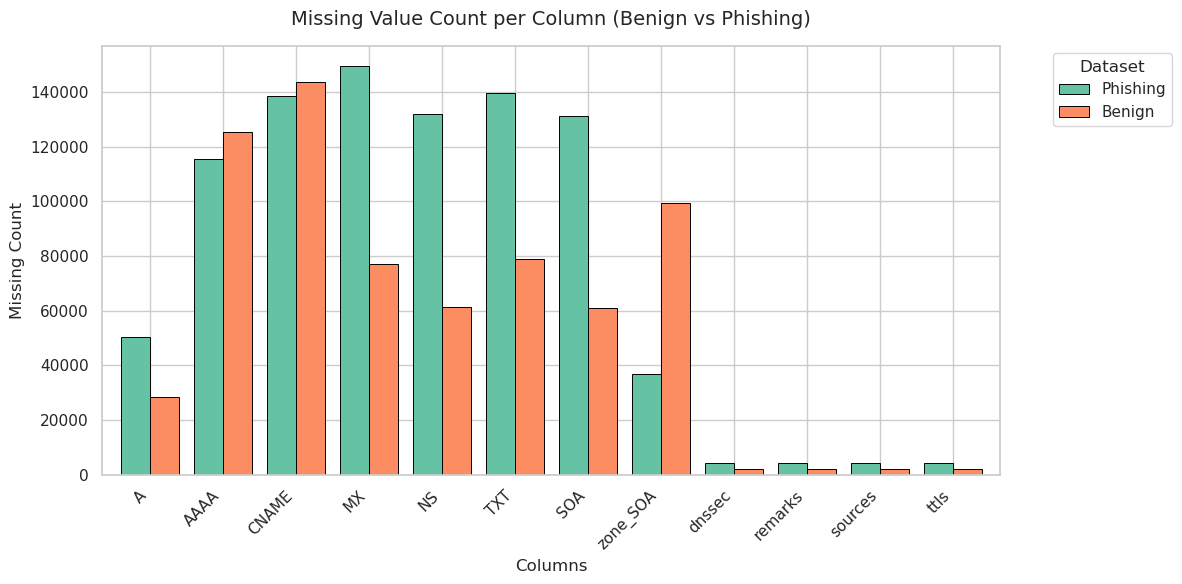

In [14]:
# Compute and visualize missing value counts across both datasets
missing_counts = pd.DataFrame({
    "Phishing": phish_df.isna().sum(),
    "Benign": benign_df.isna().sum()
})

# Filter to only columns that contain any missing values
missing_counts = missing_counts[(missing_counts > 0).any(axis=1)]

# Plot missing value counts
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", n_colors=2)

ax = missing_counts.plot(
    kind='bar',
    color=colors,
    width=0.8,
    edgecolor='black',
    linewidth=0.7,
    figsize=(12, 6)
)

ax.set_title("Missing Value Count per Column (Benign vs Phishing)", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

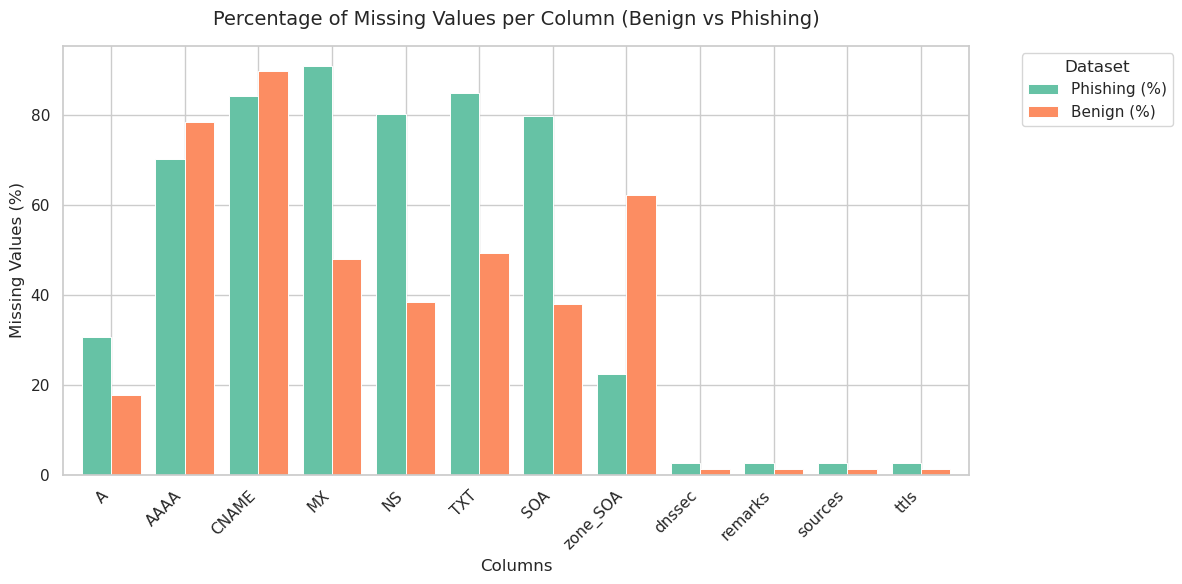

In [15]:
# Calculate percentage of missing values per column
missing_pct = pd.DataFrame({
    "Phishing (%)": phish_df.isna().mean() * 100,
    "Benign (%)": benign_df.isna().mean() * 100
})

# Keep only columns with any missing values
missing_pct = missing_pct[(missing_pct > 0).any(axis=1)]

# Plot missing value percentages
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", n_colors=2)

ax = missing_pct.plot(
    kind="bar",
    color=colors,
    width=0.8,
    linewidth=0.7,
    figsize=(12, 6)
)

ax.set_title("Percentage of Missing Values per Column (Benign vs Phishing)", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Values (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [16]:
def cohens_h(p1: float, p2: float) -> float:
    """
    Compute Cohen's h — effect size between two proportions.
    """
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

# Store effect size results
effect_sizes = {}

# Compare missingness column by column
for col in benign_df.columns:
    p_benign = benign_df[col].isna().mean()
    p_phish = phish_df[col].isna().mean()
    h = abs(cohens_h(p_phish, p_benign))  # Absolute effect size

    effect_sizes[col] = {
        'Benign Missing %': p_benign * 100,
        'Malware Missing %': p_phish * 100,
        "Cohen's h": h
    }

# Create and sort a DataFrame of results
effect_df = pd.DataFrame(effect_sizes).T.sort_values("Cohen's h", ascending=False)

print("Cohen's h and missing value percentages by column:")
print(effect_df.round(3))

# Identify columns with low effect size
threshold = 0.2
features_to_drop = effect_df[effect_df["Cohen's h"] < threshold].index.tolist()

print(f"\nFeatures recommended to drop (Cohen's h < {threshold}):")
print(features_to_drop)


Cohen's h and missing value percentages by column:
             Benign Missing %  Malware Missing %  Cohen's h
MX                     48.078             90.846      0.994
NS                     38.324             80.208      0.884
SOA                    38.091             79.856      0.880
zone_SOA               62.165             22.395      0.831
TXT                    49.245             84.927      0.788
A                      17.738             30.714      0.305
AAAA                   78.420             70.186      0.189
CNAME                  89.869             84.280      0.168
dnssec                  1.233              2.660      0.105
sources                 1.233              2.660      0.105
remarks                 1.233              2.660      0.105
ttls                    1.233              2.660      0.105
domain_name             0.000              0.000      0.000

Features recommended to drop (Cohen's h < 0.2):
['AAAA', 'CNAME', 'dnssec', 'sources', 'remarks', 'ttls', 'd

In [17]:
from scipy.stats import chi2_contingency

def is_missing(x) -> int:
    """
    Return 1 if the value is considered missing (NaN, empty string, empty list/array), else 0.
    """
    if isinstance(x, (list, np.ndarray)):
        return int(len(x) == 0)
    if isinstance(x, str) and x.strip() == "":
        return 1
    if pd.isna(x):
        return 1
    return 0


# Label datasets and concatenate
benign_df["label"] = 0
phish_df["label"] = 1
df = pd.concat([benign_df, phish_df], ignore_index=True)
print(f"Combined dataset shape: {df.shape}")

# Analyze missingness per column using Chi-square test
missing_stats = {}

for col in df.columns:
    if col == "label":
        continue

    indicator = df[col].apply(is_missing)
    overall_missing = indicator.mean()

    contingency = pd.crosstab(indicator, df["label"])
    if contingency.shape[1] == 2:
        _, p_value, _, _ = chi2_contingency(contingency)
    else:
        p_value = 1.0

    missing_stats[col] = {
        "Overall Missing Rate": overall_missing,
        "Chi-Square p-value": p_value,
        "Contingency Table": contingency
    }

    print(f"Column: {col}")
    print(f"  Missing Rate: {overall_missing:.2f}")
    print(f"  Chi-Square p-value: {p_value:.4f}")
    print(f"  Contingency Table:\n{contingency}\n")

# Decide what to drop: missing rate > 70% and not significantly different by class
columns_to_drop = [
    col for col, stats in missing_stats.items()
    if stats["Overall Missing Rate"] > 0.7 and stats["Chi-Square p-value"] > 0.05
]

print("\nColumns recommended for removal based on high missingness and low statistical signal:")
print(columns_to_drop)


Combined dataset shape: (324425, 14)
Column: domain_name
  Missing Rate: 0.00
  Chi-Square p-value: 1.0000
  Contingency Table:
label             0       1
domain_name                
0            160000  164425

Column: A
  Missing Rate: 0.24
  Chi-Square p-value: 0.0000
  Contingency Table:
label       0       1
A                    
0      131619  113923
1       28381   50502

Column: AAAA
  Missing Rate: 0.74
  Chi-Square p-value: 0.0000
  Contingency Table:
label       0       1
AAAA                 
0       34528   49022
1      125472  115403

Column: CNAME
  Missing Rate: 0.87
  Chi-Square p-value: 0.0000
  Contingency Table:
label       0       1
CNAME                
0       16210   25848
1      143790  138577

Column: MX
  Missing Rate: 0.70
  Chi-Square p-value: 0.0000
  Contingency Table:
label      0       1
MX                  
0      83075   15052
1      76925  149373

Column: NS
  Missing Rate: 0.60
  Chi-Square p-value: 0.0000
  Contingency Table:
label      0       1


In [18]:
# Get columns with over 70% missing values in both datasets
missing_threshold = 0.70

phish_missing_pct = phish_df.isna().mean()
benign_missing_pct = benign_df.isna().mean()

phish_high_missing = phish_missing_pct[phish_missing_pct > missing_threshold].index
benign_high_missing = benign_missing_pct[benign_missing_pct > missing_threshold].index

# Union of both sets
features_high_missing = set(phish_high_missing).union(benign_high_missing)

print(f"Columns with > {missing_threshold*100:.0f}% missing in at least one dataset:")
print(sorted(features_high_missing))

Columns with > 70% missing in at least one dataset:
['AAAA', 'CNAME', 'MX', 'NS', 'SOA', 'TXT']


### Inspection of columns which should be dropped according to statistical analysis

#### MX

In [ ]:
# Inspect the MX field distribution across both datasets
if "MX" in benign_df.columns:
    print("MX field (benign):")
    print(benign_df["MX"].value_counts(dropna=False))

if "MX" in phish_df.columns:
    print("\nMX field (phishing):")
    print(phish_df["MX"].value_counts(dropna=False))

### Dropping the columns

In [19]:
# Manually preserve important fields despite high missingness
excluded_from_drop = {"MX", "NS", "SOA"}

# Fields known to be sparse or numerical noise
numerical_columns = ["A", "dnssec", "sources"]

# Combine drop candidates from statistical and manual filtering
columns_to_drop = list((features_high_missing - excluded_from_drop) | set(numerical_columns))

print("Final columns to drop:")
print(sorted(columns_to_drop))

# Drop from both datasets
benign_df.drop(columns=columns_to_drop, inplace=True)
phish_df.drop(columns=columns_to_drop, inplace=True)

Final columns to drop:
['A', 'AAAA', 'CNAME', 'TXT', 'dnssec', 'sources']


In [20]:
render_dataframe(benign_df, max_rows=100, max_cols=50)

,domain_name,MX,NS,SOA,zone_SOA,remarks,ttls,label
0,00000fs3085d.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
1,0000100b00e9.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
2,0000100q012c.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
3,0000102n02c4.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
4,0000102n02d5.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
5,0000102n03d3.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
6,0000102n0434.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
7,000010560066.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
8,0000105600be.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
9,000010640021.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0


In [21]:
render_dataframe(phish_df, max_rows=100, max_cols=50)

,domain_name,MX,NS,SOA,zone_SOA,remarks,ttls,label
0,conflrma57843.com,None,"{'aisha.ns.cloudflare.com': {'related_ips': [{'ttl': 82617, 'value': '108.162.194.186'}, {'ttl': 82617, 'value': '162.159.38.186'}, {'ttl': 82617, 'value': '172.64.34.186'}, {'ttl': 81928, 'value': '2803:f800:50::6ca2:c2ba'}, {'ttl': 81928, 'value': '2a06:98c1:50::ac40:22ba'}, {'ttl': 81928, 'value': '2606:4700:50::a29f:26ba'}]}, 'rommy.ns.cloudflare.com': {'related_ips': [{'ttl': 54785, 'value': '108.162.195.20'}, {'ttl': 54785, 'value': '162.159.44.20'}, {'ttl': 54785, 'value': '172.64.35.20'}, {'ttl': 60359, 'value': '2803:f800:50::6ca2:c314'}, {'ttl': 60359, 'value': '2a06:98c1:50::ac40:2314'}, {'ttl': 60359, 'value': '2606:4700:58::a29f:2c14'}]}}","{'primary_ns': 'aisha.ns.cloudflare.com', 'resp_mailbox_dname': 'dns.cloudflare.com', 'serial': 2339702964, 'refresh': 10000, 'retry': 2400, 'expire': 604800, 'min_ttl': 1800}",None,"{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'conflrma57843.com'}","{'A': 300, 'AAAA': 300, 'SOA': 1800, 'CNAME': 0, 'MX': 0, 'NS': 86400, 'TXT': 0, 'NAPTR': 0}",1
1,www.zgahdjm.com,None,None,None,None,nan,nan,1
2,attt.pages.dev,None,"{'lily.ns.cloudflare.com': {'related_ips': [{'ttl': 85625, 'value': '173.245.58.130'}, {'ttl': 85625, 'value': '108.162.192.130'}, {'ttl': 85625, 'value': '172.64.32.130'}, {'ttl': 83677, 'value': '2606:4700:50::adf5:3a82'}, {'ttl': 83677, 'value': '2803:f800:50::6ca2:c082'}, {'ttl': 83677, 'value': '2a06:98c1:50::ac40:2082'}]}, 'watson.ns.cloudflare.com': {'related_ips': [{'ttl': 83409, 'value': '172.64.35.23'}, {'ttl': 83409, 'value': '108.162.195.23'}, {'ttl': 83409, 'value': '162.159.44.23'}, {'ttl': 84450, 'value': '2606:4700:58::a29f:2c17'}, {'ttl': 84450, 'value': '2803:f800:50::6ca2:c317'}, {'ttl': 84450, 'value': '2a06:98c1:50::ac40:2317'}]}}","{'primary_ns': 'lily.ns.cloudflare.com', 'resp_mailbox_dname': 'dns.cloudflare.com', 'serial': 2327161952, 'refresh': 10000, 'retry': 2400, 'expire': 604800, 'min_ttl': 1800}",None,"{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'attt.pages.dev'}","{'A': 300, 'AAAA': 300, 'SOA': 1800, 'CNAME': 0, 'MX': 0, 'NS': 86400, 'TXT': 0, 'NAPTR': 0}",1
3,chermate.weeblysite.com,None,None,None,"{'primary_ns': 'dns1.p08.nsone.net', 'resp_mailbox_dname': 'hostmaster.nsone.net', 'serial': 1647889018, 'refresh': 43200, 'retry': 7200, 'expire': 1209600, 'min_ttl': 3600}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'weeblysite.com'}","{'A': 900, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",1
4,allegrolokalnie.oferta73.pl,None,"{'ns1.dns-expired.com': {'related_ips': [{'ttl': 14147, 'value': '89.116.146.145'}]}, 'ns2.dns-expired.com': {'related_ips': [{'ttl': 14730, 'value': '89.116.146.146'}]}}","{'primary_ns': 'ns1.dns-expired.com', 'resp_mailbox_dname': 'hostmaster.hostinger.com', 'serial': 2023081800, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 3600}",None,"{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'allegrolokalnie.oferta73.pl'}","{'A': 3600, 'AAAA': 0, 'SOA': 3600, 'CNAME': 0, 'MX': 0, 'NS': 3600, 'TXT': 3600, 'NAPTR': 0}",1
5,validarnavegador.com,None,None,None,"{'primary_ns': 'a.gtld-servers.net', 'resp_mailbox_dname': 'nstld.verisign-grs.com', 'serial': 1698658384, 'refresh': 1800, 'retry': 900, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': True, 'zone_dnskey_selfsign_ok': True, 'zone': 'com'}","{'A': 0, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",1
6,contraato.salonqs.cl,None,None,None,"{'primary_ns': 'ns1.sitiodns.net', 'resp_mailbox_dname': 'jsotom.gmail.com', 'serial': 2024041200, 'refresh': 3600, 'retry': 7200, 'expire': 1209600, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'salonqs.cl'}","{'A': 0, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",1
7,assets-project-cloud.reconfirmation-zip.workers.dev,None,None,None,"{'primar

In [25]:
# Identify feature columns excluding identifiers and label
cols_to_check = [col for col in benign_df.columns if col not in ['domain_name', 'label']]

# Detect rows with all NaNs across feature columns
mask_all_nan_benign = benign_df[cols_to_check].isna().all(axis=1)
mask_all_nan_phish = phish_df[cols_to_check].isna().all(axis=1)

# Count how many such rows exist in each dataset
print(f"Rows with all features missing in benign dataset: {mask_all_nan_benign.sum()}")
print(f"Rows with all features missing in phishing dataset: {mask_all_nan_phish.sum()}")

# Drop these rows to maintain meaningful data
benign_df.drop(index=benign_df[mask_all_nan_benign].index, inplace=True)
phish_df.drop(index=phish_df[mask_all_nan_phish].index, inplace=True)

# Confirm new shapes
print(f"Benign dataset shape after dropping empty rows: {benign_df.shape}")
print(f"Phishing dataset shape after dropping empty rows: {phish_df.shape}")


Rows with all features missing in benign dataset: 0
Rows with all features missing in phishing dataset: 0
Benign dataset shape after dropping empty rows: (158027, 8)
Phishing dataset shape after dropping empty rows: (160052, 8)


In [23]:
# Inspect unique keys within nested dictionary columns to understand their structure
columns_to_check = ["remarks", "SOA"]

for col in columns_to_check:
    unique_keys = set()
    # Use combined DataFrame 'df' which includes both benign and phishing
    if col in df.columns:
        for cell in df[col]:
            if isinstance(cell, dict):
                unique_keys.update(cell.keys())
        print(f"Unique keys in '{col}': {sorted(unique_keys)}")
    else:
        print(f"Column '{col}' not found in DataFrame")

Unique keys in 'remarks': ['has_dkim', 'has_dmarc', 'has_dnskey', 'has_spf', 'zone', 'zone_dnskey_selfsign_ok']
Unique keys in 'SOA': ['expire', 'min_ttl', 'primary_ns', 'refresh', 'resp_mailbox_dname', 'retry', 'serial']


<Figure size 1200x600 with 0 Axes>

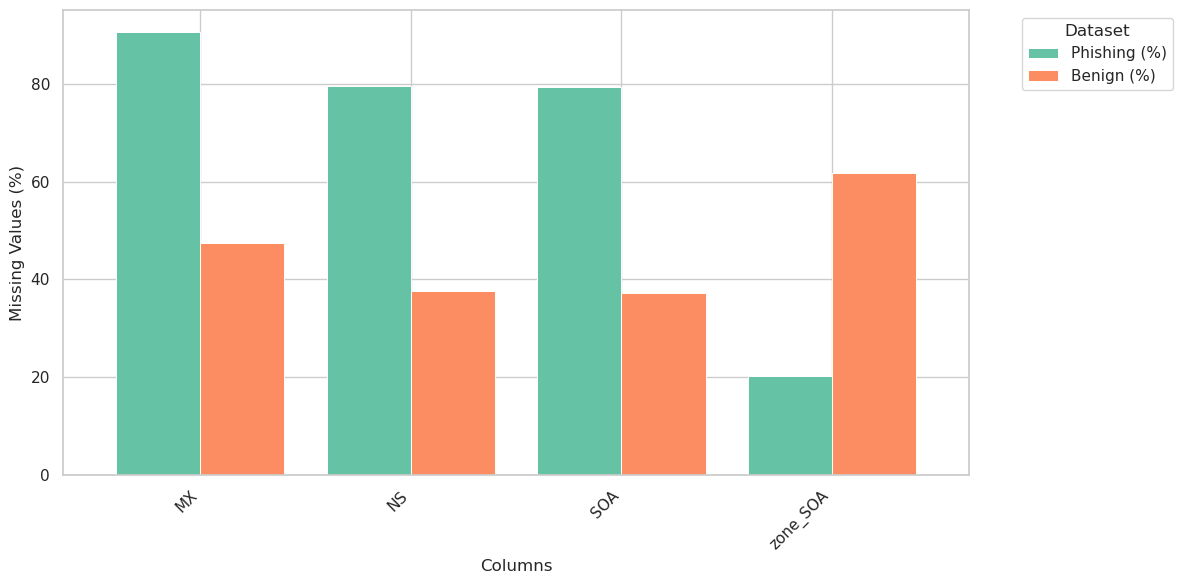

In [26]:
# Calculate percentage of missing values for phishing and benign datasets
missing_pct = pd.DataFrame({
    "Phishing (%)": phish_df.isna().mean() * 100,
    "Benign (%)": benign_df.isna().mean() * 100,
})

# Filter only columns with any missing values
missing_pct = missing_pct[(missing_pct > 0).any(axis=1)]

# Plot the missing value percentages
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", n_colors=2)

ax = missing_pct.plot(
    kind="bar",
    color=colors,
    width=0.8,
    linewidth=0.7,
    figsize=(12, 6)
)

ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Values (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Phase 3: Preparing the DataFrame for Transformer Training

In this phase, the cleaned DNS metadata are transformed into a format suitable for transformer models. This involves concatenating relevant textual fields into a single string per domain, which will later be tokenized and fed into the model.

In [27]:
benign_df['NS'] = benign_df['NS'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else x)
phish_df['NS'] = phish_df['NS'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else x)

For training the transformer, it is neccessary to create a one concatenated string with fields from analyzed dataframe

In [28]:
def prepare_input_string(row):
    CLS_TOKEN = "[CLS]"
    SEP_TOKEN = "[SEP]"
    tokens = []
    
    # Normalize domain name: lowercase, strip leading 'www.'
    domain = row.get("domain_name", "NA")
    if isinstance(domain, str):
        domain = domain.lower().lstrip("www.")
    else:
        domain = "NA"
    tokens.append(f"domain: {domain}")
    
    # Extract MX keys if present
    mx = row.get("MX")
    if isinstance(mx, dict) and mx:
        mx_keys = list(mx.keys())
        tokens.append(f"MX: {', '.join(mx_keys)}")
    else:
        tokens.append("MX: NA")
    
    # Format NS as comma-separated string
    ns = row.get("NS")
    if isinstance(ns, list) and ns:
        tokens.append(f"NS: {', '.join(ns)}")
    else:
        tokens.append("NS: NA")
    
    # Extract primary_ns and resp_mailbox_dname from SOA
    soa = row.get("SOA")
    if isinstance(soa, dict):
        primary_ns = soa.get("primary_ns", "NA")
        resp_mailbox_dname = soa.get("resp_mailbox_dname", "NA")
        tokens.append(f"SOA: primary_ns: {primary_ns} | resp_mailbox_dname: {resp_mailbox_dname}")
    else:
        tokens.append("SOA: NA")
    
    # Same for zone_SOA
    zone_soa = row.get("zone_SOA")
    if isinstance(zone_soa, dict):
        primary_ns_z = zone_soa.get("primary_ns", "NA")
        resp_mailbox_dname_z = zone_soa.get("resp_mailbox_dname", "NA")
        tokens.append(f"zone_SOA: primary_ns: {primary_ns_z} | resp_mailbox_dname: {resp_mailbox_dname_z}")
    else:
        tokens.append("zone_SOA: NA")
    
    # Process remarks, include only string-valued keys
    remarks = row.get("remarks")
    if isinstance(remarks, dict):
        filtered_pairs = [f"{k}: {v}" for k, v in remarks.items() if isinstance(v, str) and v.strip() != ""]
        remarks_str = " | ".join(filtered_pairs) if filtered_pairs else "NA"
        tokens.append(f"remarks: {remarks_str}")
    else:
        tokens.append("remarks: NA")
    
    # Concatenate all tokens with [SEP] between, wrapped by [CLS] and [SEP]
    return f"{CLS_TOKEN} " + f" {SEP_TOKEN} ".join(tokens) + f" {SEP_TOKEN}"

In [29]:
# Apply formatting function to prepare input strings for transformer
benign_df["input_string"] = benign_df.apply(prepare_input_string, axis=1)
phish_df["input_string"] = phish_df.apply(prepare_input_string, axis=1)

# Combine datasets with labels into a single DataFrame for training
combined_df = pd.concat(
    [benign_df[["input_string", "label"]], phish_df[["input_string", "label"]]],
    ignore_index=True,
)

# Shuffle rows to mix benign and phishing samples
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display first few rows for verification
print(combined_df.head())

                                        input_string  label
0  [CLS] domain: tvetreform.org.pk [SEP] MX: mx2....      0
1  [CLS] domain: bonjour.alsace [SEP] MX: alt1.as...      0
2  [CLS] domain: lowcarb.institute [SEP] MX: smtp...      0
3  [CLS] domain: tend.kiev.ua [SEP] MX: mx15.ukra...      0
4  [CLS] domain: jamricgayojs04.pages.dev [SEP] M...      1


In [30]:
# combined_df.info()
# save_path = project_root / "datasets" / "phishing" / "dns_phishing_preprocessed.csv"
# combined_df.to_csv(save_path, index=False)
